In [1]:
import os

from matplotlib import pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from torchvision import datasets, models, transforms
import torch
from functools import reduce
from typing import Union
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from pathlib import Path

%load_ext autoreload
%autoreload 2

In [2]:
### Let's have a cell with global hyperparameters for the CNNs in this notebook

# Path to a directory with image dataset and subfolders for training, validation and final testing
DATA_PATH = "../datasets"  # PATH TO THE DATASET

# Number of threads for data loader
NUM_WORKERS = 4

# Image size: even though image sizes are bigger than 96, we use this to speed up training
SIZE_H = SIZE_W = 224
N_CHANNELS = 3

# Number of classes in the dataset
NUM_CLASSES = 2

# Epochs: number of passes over the training data, we use it this small to reduce training babysitting time
EPOCH_NUM = 30

# Batch size: for batch gradient descent optimization, usually selected as 2**K elements
BATCH_SIZE = 32

# Images mean and std channelwise
image_mean = [0.485, 0.456, 0.406]
image_std = [0.229, 0.224, 0.225]

# Last layer (embeddings) size for CNN models
EMBEDDING_SIZE = 256

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [4]:
transformer = transforms.Compose(
    [
        transforms.Resize((SIZE_H, SIZE_W)),  # scaling images to fixed size
        transforms.ToTensor(),  # converting to tensors
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0) if x.shape[0] == 1 else x
        ),  # treat gray images
        transforms.Normalize(image_mean, image_std),  # normalize image data per-channel
    ]
)

## Prepare data

In [5]:
caltech101 = torchvision.datasets.Caltech101(
    root=DATA_PATH, download=True, transform=transformer
)
torch.manual_seed(0)
train_dataset, val_dataset = torch.utils.data.random_split(caltech101, [7000, 1677])

caltech101_unchanged = torchvision.datasets.Caltech101(root=DATA_PATH, download=True)
torch.manual_seed(0)
train_dataset_unchanged, val_dataset_unchanged = torch.utils.data.random_split(
    caltech101_unchanged, [7000, 1677]
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
n_train, n_val = len(train_dataset), len(val_dataset)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
)

## Finetune VGG16

In [7]:
""" VGG16
    """
num_classes = 101
model_ft = models.vgg16(pretrained=True)
model_ft.classifier[6] = nn.Linear(model_ft.classifier[6].in_features, num_classes)
model_ft.to(device);

/home/devel/ws.leonid/lectures/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/devel/ws.leonid/lectures/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
def compute_accuracy(model, val_loader):
    val_accuracy = []
    for X_batch, y_batch in val_loader:
        # move data to target device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # compute logits
        logits = model(X_batch)
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return val_accuracy


def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs):
    """
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    """
    train_loss = []
    val_accuracy = []

    for epoch in range(n_epochs):
        start_time = time.time()

        model.train(True)  # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            opt.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            #             torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            opt.step()
            train_loss.append(loss.item())

        model.train(False)  # disable dropout / use averages for batch_norm
        val_accuracy += compute_accuracy(model, val_loader)

        # print the results for this epoch:
        print(f"Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s")

        train_loss_value = np.mean(train_loss[-n_train // BATCH_SIZE :])
        val_accuracy_value = np.mean(val_accuracy[-n_val // BATCH_SIZE :]) * 100

        print(f"  training loss (in-iteration): \t{train_loss_value:.6f}")
        print(f"  validation accuracy: \t\t\t{val_accuracy_value:.2f} %")

    return train_loss, val_accuracy

In [9]:
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
train_loss, val_accuracy = train_model(model_ft,
                                         train_loader,
                                         val_loader,
                                         loss_fn,
                                         optimizer_ft,
                                         EPOCH_NUM)

KeyboardInterrupt: 

In [10]:
# torch.save(model_ft.state_dict(), '../data/vgg16.pt')

# load model

num_classes = 101
model_ft = models.vgg16(pretrained=True)
model_ft.classifier[6] = nn.Linear(model_ft.classifier[6].in_features, num_classes)
model_ft.to(device)
model_ft.load_state_dict(torch.load("../data/vgg16.pt"))
model_ft.eval();

In [11]:
np.mean(compute_accuracy(model_ft, val_loader)) * 100

94.81585631349783

# Visualize nn

In [12]:
import sys

sys.path.append("/home/devel/ws.leonid/lectures")
from l5_visualization.scripts.visualize_cnn import get_explanations

In [13]:
image_index = 44
image_unchanged, image_category = val_dataset_unchanged[image_index]
image_transformed = torch.unsqueeze(transformer(image_unchanged), 0).to(device)
get_explanations(
    model_ft,
    image_transformed,
    image_unchanged,
    caltech101.categories[image_category],
    image_category,
    Path("../outputs/test.png"),
)

/home/devel/ws.leonid/lectures/.venv/lib/python3.8/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


# Visualize dataset

 16%|█▋        | 275/1677 [06:46<34:31,  1.48s/it]  


KeyboardInterrupt: 

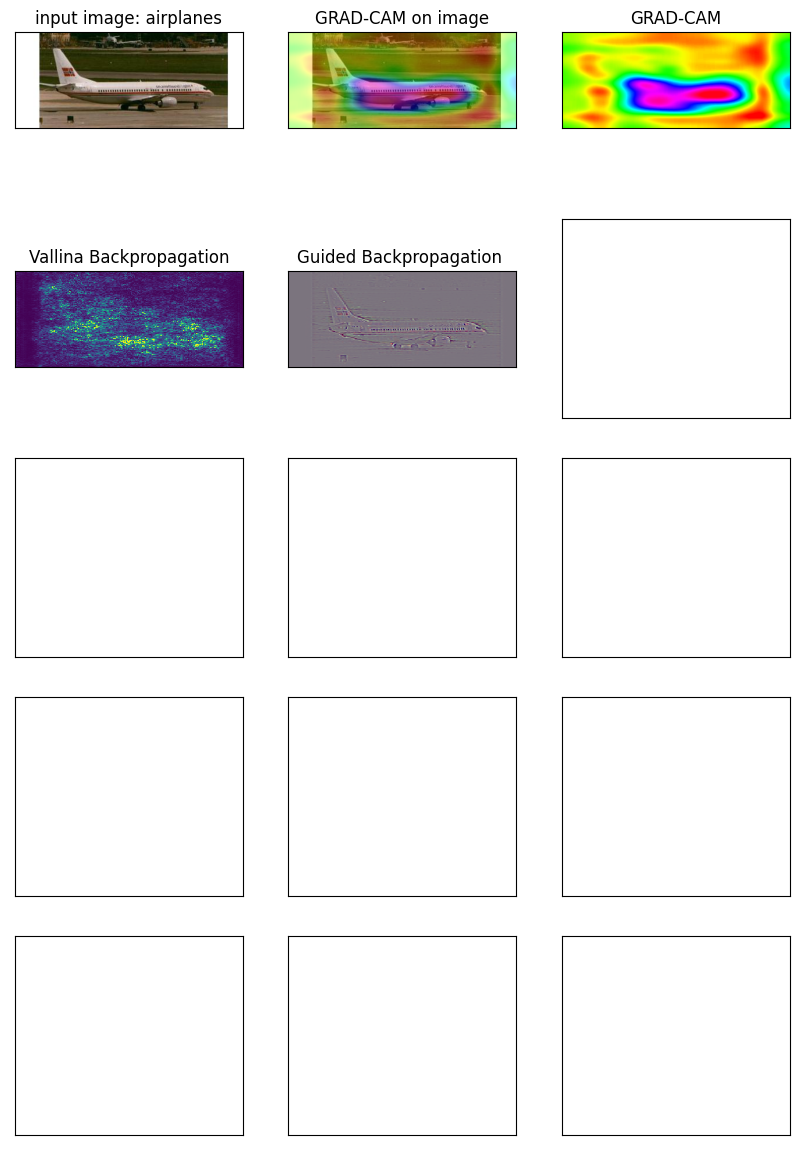

In [14]:
model_ft.eval()
out_dir = Path("../outputs/caltech101_vis/")
for image_index in tqdm(range(len(val_dataset_unchanged))):
    image_unchanged, image_category = val_dataset_unchanged[image_index]
    true_category_name = caltech101.categories[image_category]
    # prepare image
    image_transformed = torch.unsqueeze(transformer(image_unchanged), 0).to(device)
    # get class scores
    class_scores = model_ft(image_transformed)
    class_scores = class_scores.detach().cpu().numpy()[0]
    predicted_class = np.argmax(class_scores)

    formated_image_index = str(image_index).zfill(4)

    if predicted_class == image_category:
        # right classified image. Save its visualization to foulder with class category name

        save_path = out_dir / Path(
            f"true/{true_category_name}_id_{image_category}/{formated_image_index}.png"
        )
        get_explanations(
            model_ft,
            image_transformed,
            image_unchanged,
            true_category_name,
            image_category,
            save_path,
        )
    else:
        # misclassified image. Save vis with respect to true and predicted classes
        predicted_category_name = caltech101.categories[predicted_class]
        predicted_class_score = str(round(class_scores[predicted_class], 3))
        true_class_score = str(round(class_scores[image_category], 3))
        save_path_predicted_vis = out_dir / Path(
            f"mis_class/{predicted_category_name}_id_{predicted_class}_predicted"
        )
        save_path_predicted_vis /= Path(
            f"{formated_image_index}_predicted_category({predicted_category_name})_score_{predicted_class_score}_vis.png"
        )

        save_path_true_vis = out_dir / Path(
            f"mis_class/{predicted_category_name}_id_{predicted_class}_predicted"
        )
        save_path_true_vis /= Path(
            f"{formated_image_index}_true_category({true_category_name})_score_{true_class_score}_vis.png"
        )

        # predicted target vis
        get_explanations(
            model_ft,
            image_transformed,
            image_unchanged,
            true_category_name,
            predicted_class,
            save_path_predicted_vis,
        )
        # true target vis
        get_explanations(
            model_ft,
            image_transformed,
            image_unchanged,
            true_category_name,
            image_category,
            save_path_true_vis,
        )

# Inspect model architecture

In [ ]:
# for module_pos, module in model_ft.features._modules.items():
#     print(module_pos, module)

In [ ]:
for module_pos, module in model_ft.classifier._modules.items():
    print(module_pos, module)

In [ ]:
summary(model_ft, input_size=(3, 224, 224))